In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import sys
import logging
import warnings
from pathlib import Path
import joblib
from datetime import datetime
import kagglehub
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                            roc_curve, auc, f1_score, 
                            precision_score, recall_score)
import matplotlib.dates as mdates
from scipy import stats
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['savefig.dpi'] = 300

# Check if running in Jupyter
try:
    from IPython import get_ipython
    if 'IPKernelApp' in get_ipython().config:
        from tqdm.notebook import tqdm
    else:
        from tqdm import tqdm
except:
    from tqdm import tqdm

In [3]:
# Setting up directories
BASE_DIR = Path.cwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
FIGURES_DIR = os.path.join(BASE_DIR, "figures")
MODELS_DIR = os.path.join(BASE_DIR, "models")
REPORTS_DIR = os.path.join(BASE_DIR, "reports")

# Create necessary directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

# Define color palettes
BINARY_PALETTE = ['#3498db', '#e74c3c']
MULTI_PALETTE = ['#2C3E50', '#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(REPORTS_DIR, 'malware_detection.log')),
        logging.StreamHandler(sys.stdout)
    ]
)

# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
def download_dataset():
    """Download the Kaggle dataset"""
    print("Downloading dataset...")
    try:
        temp_path = kagglehub.dataset_download("agungpambudi/network-malware-detection-connection-analysis")
        print(f"Downloaded to temporary path: {temp_path}")
        
        # Move files to the data directory
        for file in os.listdir(temp_path):
            src_file = os.path.join(temp_path, file)
            dst_file = os.path.join(DATA_DIR, file)
            shutil.copy(src_file, dst_file)
            print(f"Copied {file} to {dst_file}")
            
        print(f"Dataset files are now available in: {DATA_DIR}")
        return True
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Please ensure you have kagglehub installed and have authenticated with Kaggle")
        return False

In [5]:
def load_dataset(file_name):
    """
    Load a specified dataset file from the data directory
    """
    file_path = os.path.join(DATA_DIR, file_name)
    print(f"Loading dataset from: {file_path}")
    
    try:
        # Load the dataset with the pipe delimiter
        df = pd.read_csv(file_path, delimiter='|', low_memory=False)
        
        # Clean up the dataset - convert appropriate columns to numeric
        numeric_cols = ['duration', 'orig_bytes', 'resp_bytes']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Convert timestamp to datetime
        if 'ts' in df.columns:
            df['timestamp'] = pd.to_datetime(df['ts'], unit='s')
        
        # Print basic information about the dataset
        print(f"\nDataset shape: {df.shape}")
        print("\nColumns in the dataset:")
        print(df.columns.tolist())
        print("\nFirst 5 rows of the dataset:")
        print(df.head())
        print("\nData types:")
        print(df.dtypes)
        print("\nSummary statistics for numeric columns:")
        print(df.describe())
        
        # Check for missing values
        missing_values = df.isnull().sum()
        print("\nMissing values per column:")
        print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values")
        
        # Additional analysis for detailed labels
        if 'detailed-label' in df.columns:
            print("\nDetailed label distribution:")
            print(df['detailed-label'].value_counts())
        
        return df
    
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

In [6]:
def perform_basic_analysis(df):
    """
    Perform basic analysis on the dataset
    """
    print("\n=== Basic Analysis ===")
    
    # Check if 'label' column exists for class distribution analysis
    if 'label' in df.columns:
        print("\nClass distribution:")
        label_counts = df['label'].value_counts()
        print(label_counts)
        
        # Visualize class distribution
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(y=df['label'], palette=BINARY_PALETTE)
        plt.title('Distribution of Network Traffic Labels', fontweight='bold')
        plt.xlabel('Count')
        plt.ylabel('Label')
        
        # Add count labels to the bars
        for i, count in enumerate(label_counts.values):
            ax.text(count + 10, i, f"{count:,} ({count/len(df)*100:.1f}%)", va='center')
            
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'class_distribution.png'))
        plt.show()
        print(f"Class distribution plot saved to {os.path.join(FIGURES_DIR, 'class_distribution.png')}")
    
    # Check protocol distribution if 'proto' column exists
    if 'proto' in df.columns:
        print("\nProtocol distribution:")
        proto_counts = df['proto'].value_counts()
        print(proto_counts)
        
        # Visualize protocol distribution
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(y=df['proto'])
        plt.title('Distribution of Network Protocols', fontweight='bold')
        plt.xlabel('Count')
        plt.ylabel('Protocol')
        
        # Add count labels to the bars
        for i, count in enumerate(proto_counts.values):
            ax.text(count + 10, i, f"{count:,} ({count/len(df)*100:.1f}%)", va='center')
            
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'protocol_distribution.png'))
        plt.show()
        
        # Create stacked bar chart showing protocol distribution by label
        if 'label' in df.columns:
            plt.figure(figsize=(12, 7))
            protocol_by_label = pd.crosstab(df['proto'], df['label'], normalize='index') * 100
            protocol_by_label.plot(kind='bar', stacked=True, colormap='viridis')
            plt.title('Protocol Distribution by Traffic Type', fontweight='bold')
            plt.xlabel('Protocol')
            plt.ylabel('Percentage')
            plt.legend(title='Traffic Type')
            plt.xticks(rotation=0)
            plt.grid(axis='y', alpha=0.3)
            
            # Add percentage labels
            for n, x in enumerate([*protocol_by_label.index.values]):
                for (proportion, y_loc) in zip(protocol_by_label.loc[x], protocol_by_label.loc[x].cumsum()):
                    if proportion > 5:  # Only show labels for segments > 5%
                        plt.text(n, y_loc - proportion/2, f'{proportion:.1f}%', 
                                ha='center', color='white', fontweight='bold')
            
            plt.tight_layout()
            plt.savefig(os.path.join(FIGURES_DIR, 'protocol_by_label.png'))
            plt.show()

In [7]:
def analyze_temporal_patterns(df):
    """
    Analyze temporal patterns in the network data
    """
    print("\n=== Temporal Analysis ===")
    
    if 'timestamp' in df.columns:
        # Add hour of day column
        df['hour'] = df['timestamp'].dt.hour
        
        # Traffic volume by hour
        plt.figure(figsize=(14, 8))
        hourly_traffic = df.groupby(['hour', 'label']).size().unstack()
        hourly_traffic.plot(kind='bar', stacked=True)
        plt.title('Network Traffic Volume by Hour of Day', fontweight='bold')
        plt.xlabel('Hour')
        plt.ylabel('Number of Connections')
        plt.xticks(range(24), range(24))
        plt.grid(axis='y', alpha=0.3)
        plt.legend(title='Traffic Type')
        
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'hourly_traffic.png'))
        plt.show()
        
        # Traffic volume time series
        plt.figure(figsize=(16, 8))
        df['time_bin'] = df['timestamp'].dt.floor('10min')
        time_series = df.groupby(['time_bin', 'label']).size().unstack().fillna(0)
        
        time_series.plot()
        plt.title('Network Traffic Volume Over Time', fontweight='bold')
        plt.xlabel('Time')
        plt.ylabel('Number of Connections')
        plt.grid(True, alpha=0.3)
        plt.legend(title='Traffic Type')
        
        # Format x-axis for better readability
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
        plt.gcf().autofmt_xdate()
        
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'traffic_timeseries.png'))
        plt.show()

In [8]:
def analyze_traffic_features(df):
    """
    Analyze network traffic features
    """
    print("\n=== Traffic Feature Analysis ===")
    
    # Distribution of bytes transferred
    if all(col in df.columns for col in ['orig_bytes', 'resp_bytes']):
        # Convert to numeric if needed
        for col in ['orig_bytes', 'resp_bytes']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Create total bytes column
        df['total_bytes'] = df['orig_bytes'] + df['resp_bytes']
        
        # Plot distribution of bytes (log scale)
        plt.figure(figsize=(12, 8))
        
        # Using log scale due to potential extreme values
        for label, color in zip(['Benign', 'Malicious'], BINARY_PALETTE):
            data = df[df['label'] == label]['total_bytes'].replace(0, 0.1)  # Replace zeros for log scale
            sns.kdeplot(data, shade=True, label=label, color=color, log_scale=True)
        
        plt.title('Distribution of Data Transfer Volume by Traffic Type (Log Scale)', fontweight='bold')
        plt.xlabel('Total Bytes Transferred (log scale)')
        plt.ylabel('Density')
        plt.legend(title='Traffic Type')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'bytes_distribution.png'))
        plt.show()
        
    # Packets vs Bytes scatter plot
    if all(col in df.columns for col in ['orig_pkts', 'orig_bytes']):
        plt.figure(figsize=(12, 8))
        
        # Create a sample of the data to avoid overcrowding the plot
        sample_size = min(10000, len(df))
        sample_df = df.sample(sample_size, random_state=42)
        
        # Create the scatter plot
        sns.scatterplot(data=sample_df, x='orig_pkts', y='orig_bytes', hue='label', 
                        palette=BINARY_PALETTE, alpha=0.6, s=50)
        
        plt.title('Relationship between Packets and Bytes Sent', fontweight='bold')
        plt.xlabel('Number of Packets')
        plt.ylabel('Bytes Sent')
        plt.legend(title='Traffic Type')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'packets_vs_bytes.png'))
        plt.show()

In [9]:
def perform_dimensionality_reduction(df):
    """
    Perform PCA on numeric features for visualization
    """
    print("\n=== Dimensionality Reduction Analysis ===")
    
    # Select numeric columns for PCA
    numeric_cols = ['id.orig_p', 'id.resp_p', 'orig_pkts', 'orig_ip_bytes', 
                    'resp_pkts', 'resp_ip_bytes']
    
    # Additional columns if they exist and are numeric
    additional_cols = ['duration', 'orig_bytes', 'resp_bytes']
    for col in additional_cols:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
    
    # Check if we have the necessary columns
    if all(col in df.columns for col in numeric_cols):
        print(f"Performing PCA on columns: {numeric_cols}")
        
        # Sample data to manage memory usage
        sample_size = min(50000, len(df))
        sample_df = df.sample(sample_size, random_state=42)
        
        # Extract features and standardize
        X = sample_df[numeric_cols].fillna(0)
        X_scaled = StandardScaler().fit_transform(X)
        
        # Apply PCA
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(X_scaled)
        
        # Create a DataFrame with the principal components
        pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
        pca_df['label'] = sample_df['label'].reset_index(drop=True)
        
        # Plot the results
        plt.figure(figsize=(12, 10))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='label', palette=BINARY_PALETTE, alpha=0.6, s=50)
        
        # Add some analytics to the plot
        explained_variance = pca.explained_variance_ratio_ * 100
        plt.title('PCA of Network Traffic Features', fontweight='bold')
        plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f}% variance explained)')
        plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f}% variance explained)')
        plt.legend(title='Traffic Type')
        plt.grid(True, alpha=0.3)
        
        # Draw markers to show the distribution of each class
        for label, color in zip(['Benign', 'Malicious'], BINARY_PALETTE):
            class_data = pca_df[pca_df['label'] == label]
            mean_x = class_data['PC1'].mean()
            mean_y = class_data['PC2'].mean()
            plt.plot(mean_x, mean_y, marker='o', markersize=10, color=color)
            plt.annotate(f"Mean {label}", (mean_x, mean_y), xytext=(5, 5), 
                         textcoords='offset points', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'pca_visualization.png'))
        plt.show()
        
        # Feature importance based on PCA
        plt.figure(figsize=(12, 8))
        loadings = pca.components_.T
        df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=numeric_cols)
        
        # Plot heatmap of loadings
        sns.heatmap(df_loadings, cmap='viridis', annot=True, fmt='.2f', linewidths=0.5)
        plt.title('Feature Contributions to Principal Components', fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'pca_loadings.png'))
        plt.show()

In [10]:
def analyze_file_missing_data(df, file_name):
    """
    Analyze missing data in a single file
    
    Parameters:
    df: DataFrame to analyze
    file_name: str, name of the file for reporting
    
    Returns:
    dict: Missing value statistics
    """
    print(f"\n=== Analyzing {file_name} Missing Data ===")
    
    # Get dataset shape
    rows, cols = df.shape
    print(f"Dataset shape: {rows} rows x {cols} columns")
    
    # Calculate total missing values
    total_missing = df.isna().sum().sum()
    missing_percentage = (total_missing / (rows * cols)) * 100
    print(f"Total missing values: {total_missing} ({missing_percentage:.2f}%)")
    
    # Calculate missing values by column
    missing_by_column = df.isna().sum()
    missing_cols = missing_by_column[missing_by_column > 0].sort_values(ascending=False)
    
    if len(missing_cols) > 0:
        print("\nMissing values by column:")
        for col, count in missing_cols.items():
            col_missing_pct = (count / rows) * 100
            print(f"  {col}: {count} missing values ({col_missing_pct:.2f}%)")
    else:
        print("\nNo missing values found in any column")
    
    # For categorical features, check if there are empty strings or special values
    object_cols = df.select_dtypes(include=['object']).columns
    
    empty_strings_by_col = {}
    for col in object_cols:
        empty_count = df[col].str.strip().eq('').sum()
        if empty_count > 0:
            empty_strings_by_col[col] = empty_count
    
    if empty_strings_by_col:
        print("\nColumns with empty strings:")
        for col, count in empty_strings_by_col.items():
            empty_pct = (count / rows) * 100
            print(f"  {col}: {count} empty strings ({empty_pct:.2f}%)")
    
    # Check for zeros in numeric columns that might represent missing values
    numeric_cols = df.select_dtypes(include=['number']).columns
    zeros_by_col = {}
    for col in numeric_cols:
        zero_count = (df[col] == 0).sum()
        if zero_count > 0:
            zeros_by_col[col] = zero_count
    
    if zeros_by_col:
        print("\nNumeric columns with zero values (potential placeholders):")
        for col, count in zeros_by_col.items():
            zero_pct = (count / rows) * 100
            print(f"  {col}: {count} zeros ({zero_pct:.2f}%)")
    
    # Visualize missing data
    plt.figure(figsize=(14, 8))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title(f'Missing Data in {file_name}', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'missing_data_{file_name.replace(".", "_")}.png'))
    plt.show()
    
    return {
        'file': file_name,
        'total_rows': rows,
        'total_columns': cols,
        'total_missing': total_missing,
        'missing_percentage': missing_percentage,
        'missing_columns': len(missing_cols),
        'missing_by_column': missing_cols.to_dict()
    }

In [11]:
def preprocess_data(df):
    """
    Preprocess data for machine learning models
    """
    print("\n=== Data Preprocessing ===")
    
    # Handle missing values
    print("Handling missing values...")
    
    # For numeric columns: replace NaNs with median
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())
    
    # For categorical columns: replace NaNs with most common value
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # Convert categorical variables to numerical
    print("Converting categorical variables...")
    
    # Identify categorical columns to encode
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and col != 'label']
    
    # Create empty dictionary to store label encoders
    encoders = {}
    
    # Encode categorical features
    for col in categorical_cols:
        # For simplicity, we'll use one-hot encoding for columns with few unique values
        if df[col].nunique() < 10:
            # One-hot encoding
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat([df, dummies], axis=1)
            df.drop(col, axis=1, inplace=True)
        else:
            # For high cardinality features, use label encoding or skip
            if df[col].nunique() < 100:  # Skip if too many unique values
                df[col] = df[col].astype('category').cat.codes
    
    # Prepare features and target
    print("Preparing features and target...")
    
    # Ensure 'label' is binary (0 for 'Benign', 1 for 'Malicious')
    if 'label' in df.columns:
        df['label'] = df['label'].map({'Benign': 0, 'Malicious': 1})
    
    # Drop any non-numeric columns that remain
    df = df.select_dtypes(include=['number'])
    
    # Split features and target
    X = df.drop('label', axis=1)
    y = df['label']
    
    # Normalize features
    print("Normalizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Save feature names for later use
    feature_names = X.columns.tolist()
    
    # Split data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    
    # Save preprocessed data
    os.makedirs(PROCESSED_DIR, exist_ok=True)
    np.savez(os.path.join(PROCESSED_DIR, 'processed_data.npz'),
             X_train=X_train, X_test=X_test, 
             y_train=y_train, y_test=y_test,
             feature_names=feature_names)
    
    # Save encoders
    joblib.dump(encoders, os.path.join(PROCESSED_DIR, 'encoders.pkl'))
    
    print(f"Preprocessed data saved to {os.path.join(PROCESSED_DIR, 'processed_data.npz')}")
    
    return X_train, X_test, y_train, y_test, feature_names, encoders

def load_preprocessed_data():
    """Load the preprocessed data"""
    print("\n=== Loading Preprocessed Data ===")
    
    data_path = os.path.join(PROCESSED_DIR, 'processed_data.npz')
    
    if os.path.exists(data_path):
        data = np.load(data_path, allow_pickle=True)
        
        X_train = data['X_train']
        X_test = data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']
        features = data['feature_names']
        
        print(f"Loaded preprocessed data successfully")
        print(f"Training set: {X_train.shape[0]} samples with {X_train.shape[1]} features")
        print(f"Testing set: {X_test.shape[0]} samples with {X_test.shape[1]} features")
        
        # Print class distribution
        train_classes, train_counts = np.unique(y_train, return_counts=True)
        test_classes, test_counts = np.unique(y_test, return_counts=True)
        
        print("\nClass distribution in training set:")
        for cls, count in zip(train_classes, train_counts):
            print(f"  Class {int(cls)}: {count} samples ({count/len(y_train)*100:.2f}%)")
        
        print("\nClass distribution in testing set:")
        for cls, count in zip(test_classes, test_counts):
            print(f"  Class {int(cls)}: {count} samples ({count/len(y_test)*100:.2f}%)")
        
        # Load encoders
        encoders_path = os.path.join(PROCESSED_DIR, 'encoders.pkl')
        encoders = joblib.load(encoders_path) if os.path.exists(encoders_path) else {}
        
        return X_train, X_test, y_train, y_test, features.tolist(), encoders
    else:
        print(f"Preprocessed data not found at {data_path}")
        return None, None, None, None, None, None

In [12]:
def train_random_forest(X_train, y_train):
    """Train a Random Forest classifier"""
    print("\n=== Training Random Forest Classifier ===")
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
    print(f"Random Forest parameters: {rf.get_params()}")
    print("Fitting Random Forest model...")
    
    start_time = datetime.now()
    rf.fit(X_train, y_train)
    training_time = datetime.now() - start_time
    
    print(f"Random Forest training completed in {training_time}")
    
    # Save the model
    joblib.dump(rf, os.path.join(MODELS_DIR, "random_forest.pkl"))
    print(f"Random Forest model saved to {os.path.join(MODELS_DIR, 'random_forest.pkl')}")
    
    return rf

In [13]:
def train_xgboost(X_train, y_train):
    """Train an XGBoost classifier"""
    print("\n=== Training XGBoost Classifier ===")
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=1,
        n_jobs=-1
    )
    print(f"XGBoost parameters: {xgb_model.get_params()}")
    print("Fitting XGBoost model...")
    
    # Create an evaluation set
    eval_set = [(X_train, y_train)]
    
    start_time = datetime.now()
    xgb_model.fit(
        X_train, 
        y_train,
        eval_set=eval_set,
        verbose=True
    )
    training_time = datetime.now() - start_time
    
    print(f"XGBoost training completed in {training_time}")
    
    # Save the model
    joblib.dump(xgb_model, os.path.join(MODELS_DIR, "xgboost.pkl"))
    print(f"XGBoost model saved to {os.path.join(MODELS_DIR, 'xgboost.pkl')}")
    
    return xgb_model

In [27]:
def train_svm(X_train, y_train):
    """Train a Support Vector Machine classifier"""
    print("\n=== Training SVM Classifier ===")

    # Convert y_train to numpy array if it's a pandas Series
    if isinstance(y_train, pd.Series):
        y_train = y_train.values

    # Use a subset of data for SVM due to computational complexity
    sample_size = min(10000, X_train.shape[0])
    indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
    X_train_sample = X_train[indices]
    y_train_sample = y_train[indices]

    print(f"Using {sample_size} samples for SVM training")

    svm = SVC(kernel='rbf', probability=True, random_state=42, verbose=True)
    print(f"SVM parameters: {svm.get_params()}")
    print("Fitting SVM model (this may take some time)...")

    start_time = datetime.now()
    svm.fit(X_train_sample, y_train_sample)
    training_time = datetime.now() - start_time

    print(f"SVM training completed in {training_time}")

    # Save the model
    joblib.dump(svm, os.path.join(MODELS_DIR, "svm.pkl"))
    print(f"SVM model saved to {os.path.join(MODELS_DIR, 'svm.pkl')}")
    return svm

In [15]:
def evaluate_model(model, X_test, y_test, model_name, features=None):
    """Evaluate a model and create visualizations"""
    print(f"\n=== Evaluating {model_name} ===")
    
    # Make predictions
    print(f"Making predictions with {model_name}...")
    y_pred = model.predict(X_test)
    
    # Get probabilities (if available)
    y_prob = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    
    # Save metrics to a CSV file
    metrics_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1]
    })
    
    metrics_file = os.path.join(REPORTS_DIR, f"{model_name.replace(' ', '_').lower()}_metrics.csv")
    metrics_df.to_csv(metrics_file, index=False)
    print(f"Metrics saved to {metrics_file}")
    
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred)
    print(report)
    
    # Create confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malicious'],
                yticklabels=['Benign', 'Malicious'])
    plt.title(f'Confusion Matrix - {model_name}', fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png'))
    plt.show()
    
    # Feature importance (if available)
    if features is not None and hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        # Sort features by importance
        sorted_idx = feature_importance.argsort()[-15:]  # top 15 features
        
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
        plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
        plt.title(f'Feature Importance - {model_name}', fontweight='bold')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'feature_importance_{model_name.replace(" ", "_").lower()}.png'))
        plt.show()
    
    # Create ROC curve (if probabilities are available)
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}', fontweight='bold')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'roc_curve_{model_name.replace(" ", "_").lower()}.png'))
        plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

In [16]:
def compare_models(results, y_test):
    """Compare the performance of different models"""
    print("\n=== Model Performance Comparison ===")
    
    # Prepare data for comparison plots
    models = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models]
    precisions = [results[model]['precision'] for model in models]
    recalls = [results[model]['recall'] for model in models]
    f1_scores = [results[model]['f1'] for model in models]
    
    # Create a bar chart comparing all metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metrics_data = np.array([accuracies, precisions, recalls, f1_scores])
    
    plt.figure(figsize=(14, 8))
    x = np.arange(len(models))
    width = 0.2
    
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    for i, metric in enumerate(metrics):
        plt.bar(x + i*width, metrics_data[i], width, label=metric, color=colors[i])
    
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison', fontweight='bold')
    plt.xticks(x + width*1.5, models)
    plt.legend(loc='lower right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on top of the bars
    for i, metric_values in enumerate(metrics_data):
        for j, value in enumerate(metric_values):
            plt.text(j + i*width, value + 0.01, f'{value:.3f}', 
                     ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'model_metrics_comparison.png'))
    plt.show()
    
    # ROC curve comparison
    plt.figure(figsize=(10, 8))
    
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
    for i, (name, result) in enumerate(results.items()):
        if result['y_prob'] is not None:
            fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, color=colors[i % len(colors)],
                    label=f'{name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison', fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'roc_curves_comparison.png'))
    plt.show()
    
    # Create a table with performance metrics
    metrics_table = pd.DataFrame({
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1 Score': f1_scores
    }, index=models)
    
    print("\nPerformance Metrics:")
    print(metrics_table)
    
    # Find and print the best model for each metric
    best_model = {
        'Accuracy': models[np.argmax(accuracies)],
        'Precision': models[np.argmax(precisions)],
        'Recall': models[np.argmax(recalls)],
        'F1 Score': models[np.argmax(f1_scores)]
    }
    
    print("\nBest model for each metric:")
    for metric, model in best_model.items():
        print(f"  {metric}: {model}")
    
    return metrics_table

In [17]:
class MalwareDetectionNN(nn.Module):
    """Neural Network for IoT Malware Detection"""
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.3):
        super(MalwareDetectionNN, self).__init__()
        
        # Input layer
        layers = [nn.Linear(input_size, hidden_sizes[0]),
                  nn.BatchNorm1d(hidden_sizes[0]),
                  nn.ReLU(),
                  nn.Dropout(dropout_rate)]
        
        # Hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.extend([
                nn.Linear(hidden_sizes[i], hidden_sizes[i+1]),
                nn.BatchNorm1d(hidden_sizes[i+1]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
def train_neural_network(X_train, y_train, X_test, y_test, input_size, batch_size=64, 
                         epochs=30, learning_rate=0.001, patience=7):
    """Train a neural network for malware detection"""
    print("\n=== Training Neural Network ===")
    
    # Convert pandas Series to numpy arrays if needed
    if isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(y_test, pd.Series):
        y_test = y_test.values
    
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1))
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1))
    
    # Create PyTorch datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize the model
    model = MalwareDetectionNN(input_size)
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                    patience=5, verbose=True)
    
    # Training setup
    print(f"Neural Network architecture:\n{model}")
    print(f"Training with batch size: {batch_size}, learning rate: {learning_rate}")
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    best_model = None
    no_improve_epochs = 0
    
    start_time = datetime.now()
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        
        # Calculate average training loss and accuracy
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Track statistics
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        # Calculate average validation loss and accuracy
        val_loss = val_loss / len(test_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Early stopping
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    training_time = datetime.now() - start_time
    print(f"Training completed in {training_time}")
    
    # Load the best model
    if best_model is not None:
        model.load_state_dict(best_model)
    
    # Save the model
    torch.save(model.state_dict(), os.path.join(MODELS_DIR, "neural_network.pth"))
    print(f"Model saved to {os.path.join(MODELS_DIR, 'neural_network.pth')}")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'neural_network_training_curves.png'))
    plt.show()
    
    return model, (train_losses, val_losses, train_accs, val_accs)

In [19]:
def evaluate_neural_network(model, X_test, y_test):
    """Evaluate the neural network model"""
    print("\n=== Evaluating Neural Network ===")
    
    # Convert test data to PyTorch tensors
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_prob = model(X_test_tensor).cpu().numpy().flatten()
    
    # Convert probabilities to class labels
    y_pred = (y_prob > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("Neural Network Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    
    # Save metrics to a CSV file
    metrics_df = pd.DataFrame({
        'Model': ['Neural Network'],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1]
    })
    
    metrics_file = os.path.join(REPORTS_DIR, "neural_network_metrics.csv")
    metrics_df.to_csv(metrics_file, index=False)
    print(f"Metrics saved to {metrics_file}")
    
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred)
    print(report)
    
    # Create confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malicious'],
                yticklabels=['Benign', 'Malicious'])
    plt.title('Confusion Matrix - Neural Network', fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix_neural_network.png'))
    plt.show()
    
    # Create ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Neural Network', fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'roc_curve_neural_network.png'))
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

In [20]:
def compare_all_models(traditional_results, nn_results):
    """Compare neural network with traditional ML models"""
    print("\n=== Comparing All Models ===")
    
    # Combine all results
    all_results = traditional_results.copy()
    all_results["Neural Network"] = nn_results
    
    # Compare models
    compare_models(all_results, y_test)
    
    # Create a combined metrics CSV
    all_metrics = []
    for model_name, results in all_results.items():
        all_metrics.append({
            'Model': model_name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1 Score': results['f1']
        })
    
    all_metrics_df = pd.DataFrame(all_metrics)
    all_metrics_file = os.path.join(REPORTS_DIR, "all_models_comparison.csv")
    all_metrics_df.to_csv(all_metrics_file, index=False)
    print(f"Combined metrics saved to {all_metrics_file}")
    
    return all_metrics_df


IOT NETWORK MALWARE DETECTION PIPELINE
Downloaded to temporary path: C:\Users\user\.cache\kagglehub\datasets\agungpambudi\network-malware-detection-connection-analysis\versions\3
Copied CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv to c:\Users\user\OneDrive - Coventry University\documents\GitHub\Msc.Dissertation-Blessing-Ekwunife\data\CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv
Copied CTU-IoT-Malware-Capture-20-1conn.log.labeled.csv to c:\Users\user\OneDrive - Coventry University\documents\GitHub\Msc.Dissertation-Blessing-Ekwunife\data\CTU-IoT-Malware-Capture-20-1conn.log.labeled.csv
Copied CTU-IoT-Malware-Capture-21-1conn.log.labeled.csv to c:\Users\user\OneDrive - Coventry University\documents\GitHub\Msc.Dissertation-Blessing-Ekwunife\data\CTU-IoT-Malware-Capture-21-1conn.log.labeled.csv
Copied CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv to c:\Users\user\OneDrive - Coventry University\documents\GitHub\Msc.Dissertation-Blessing-Ekwunife\data\CTU-IoT-Malware-Capture-3-1conn.

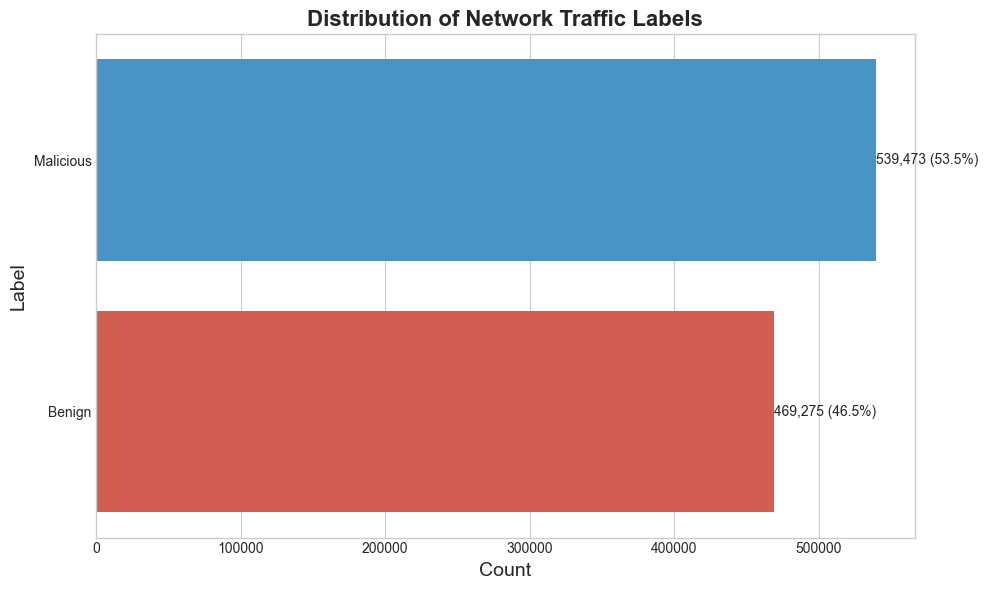

Class distribution plot saved to c:\Users\user\OneDrive - Coventry University\documents\GitHub\Msc.Dissertation-Blessing-Ekwunife\figures\class_distribution.png

Protocol distribution:
proto
tcp     583134
udp     408193
icmp     17421
Name: count, dtype: int64


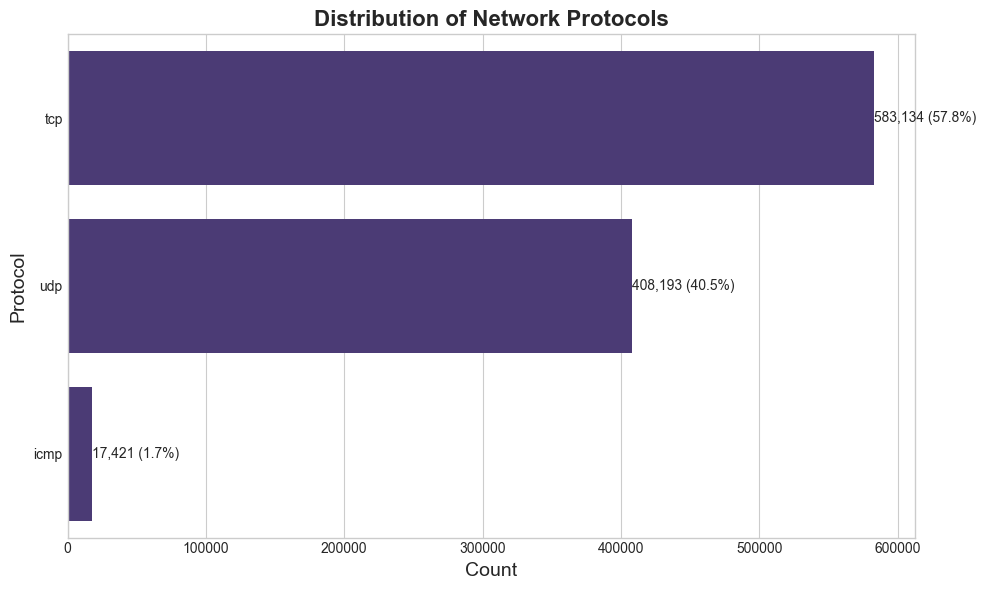

<Figure size 1200x700 with 0 Axes>

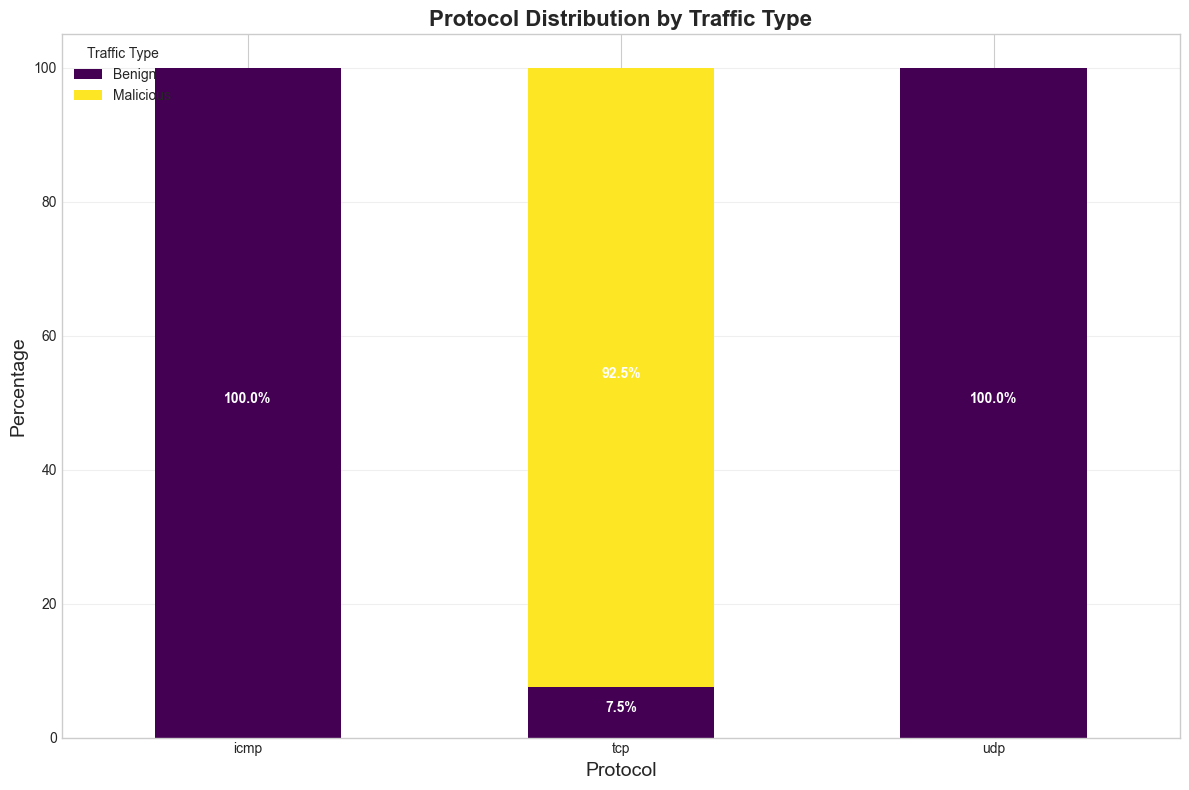


=== Temporal Analysis ===


<Figure size 1400x800 with 0 Axes>

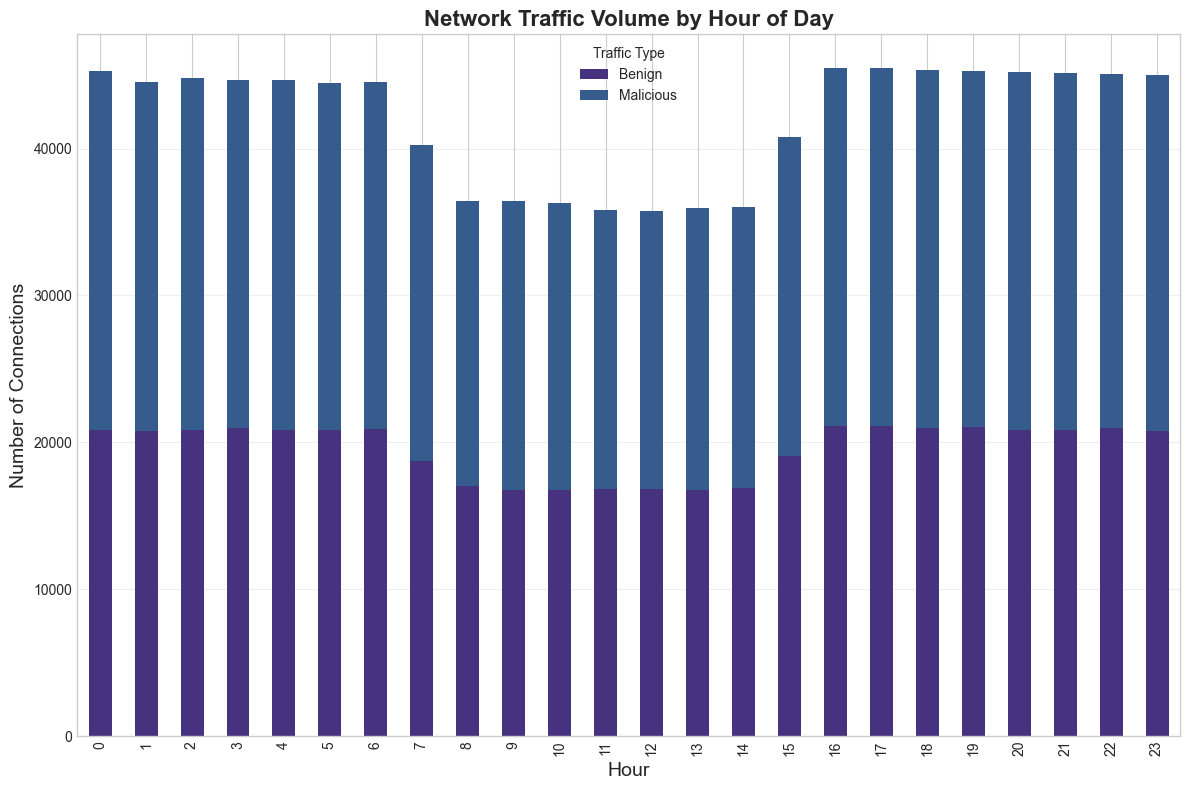

<Figure size 1600x800 with 0 Axes>

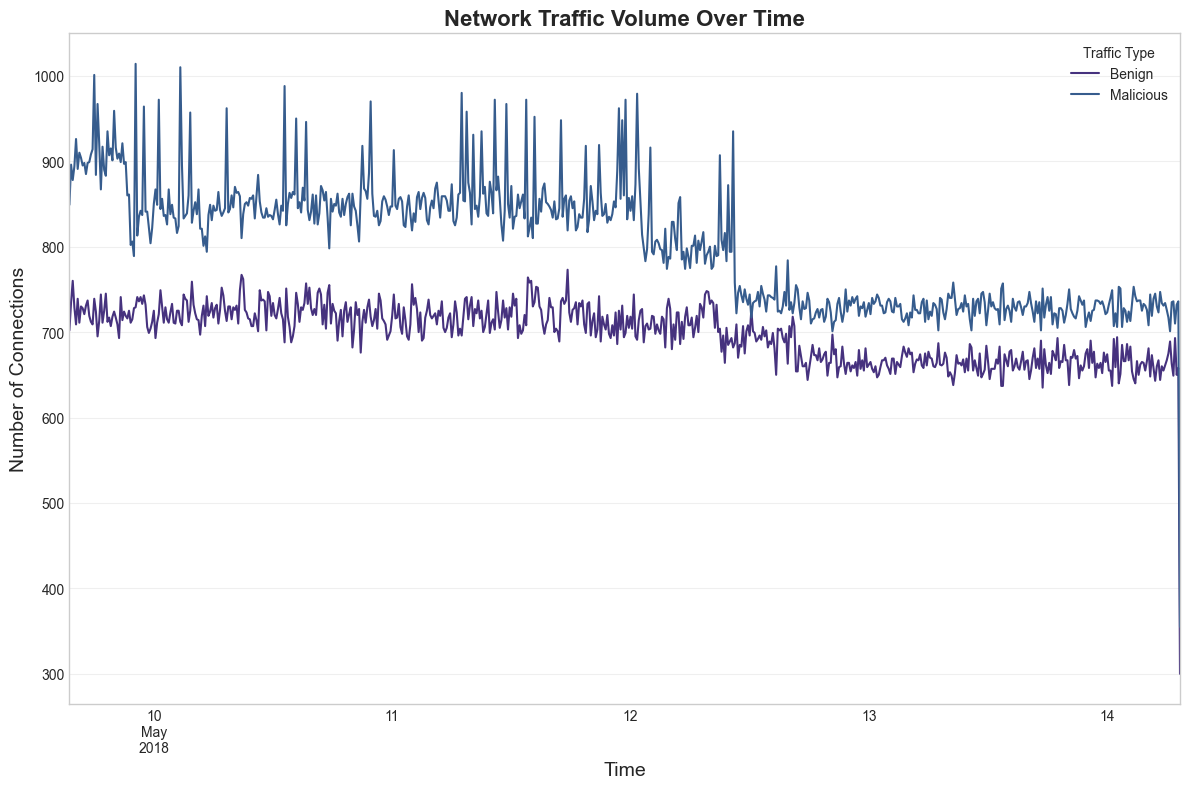


=== Traffic Feature Analysis ===


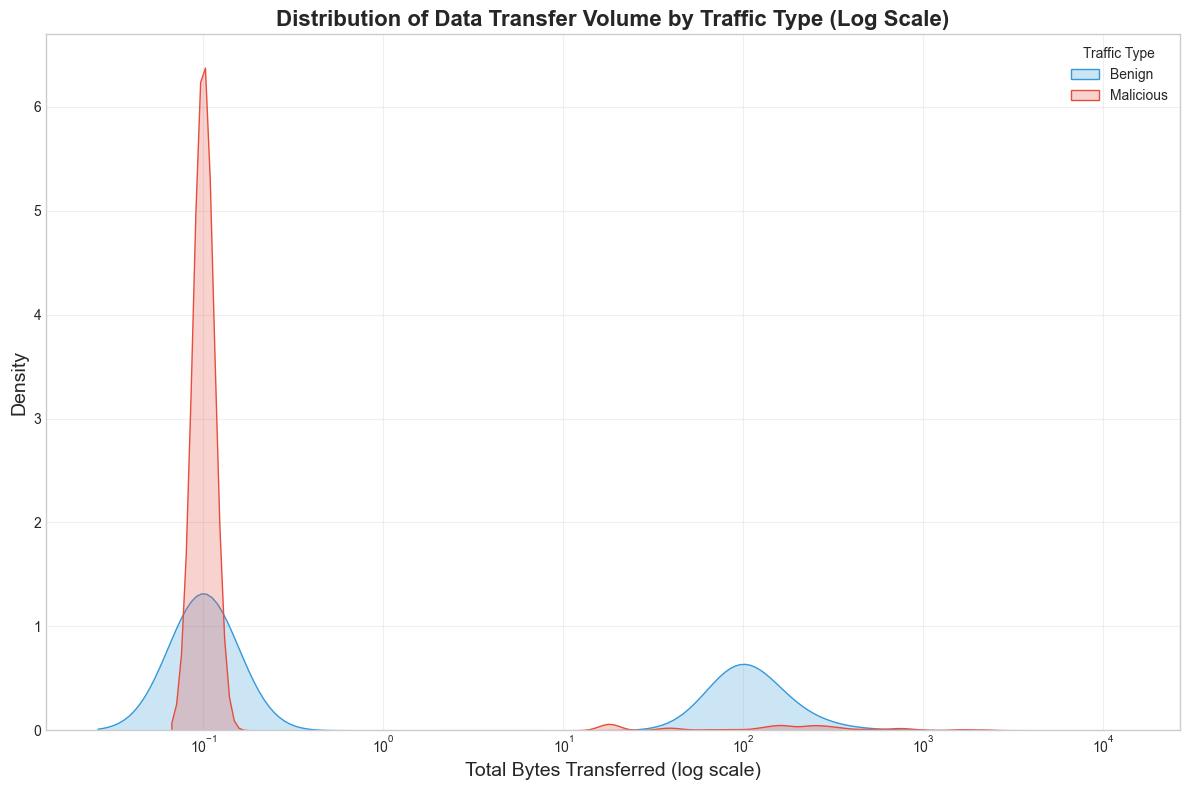

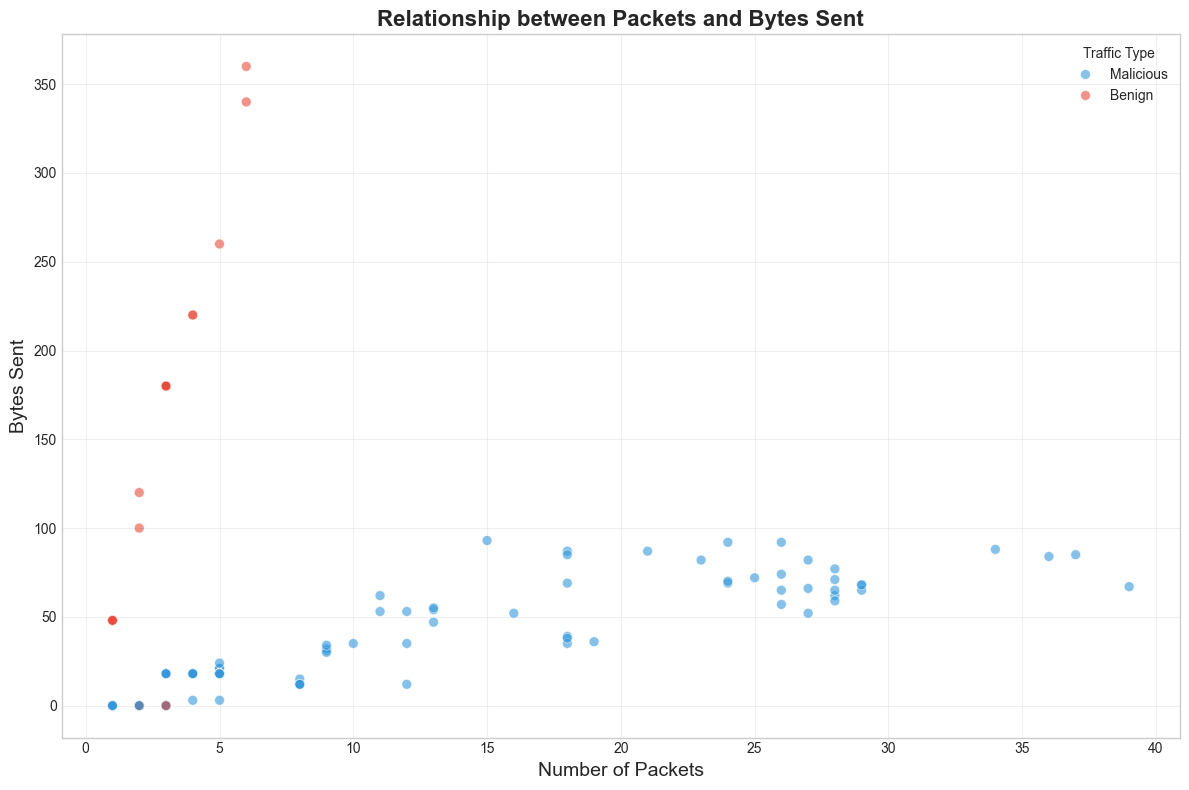


=== Dimensionality Reduction Analysis ===
Performing PCA on columns: ['id.orig_p', 'id.resp_p', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'duration', 'orig_bytes', 'resp_bytes']


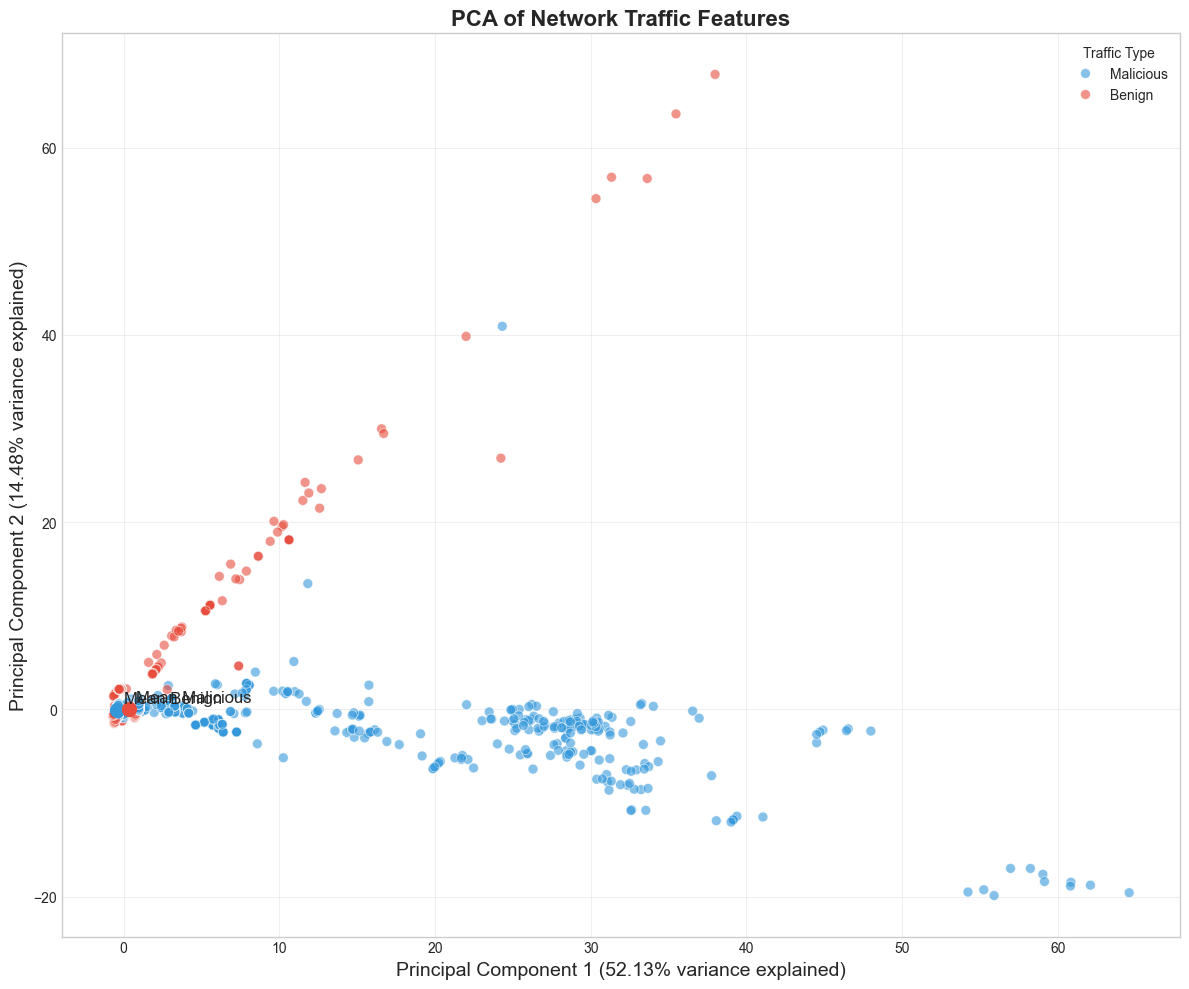

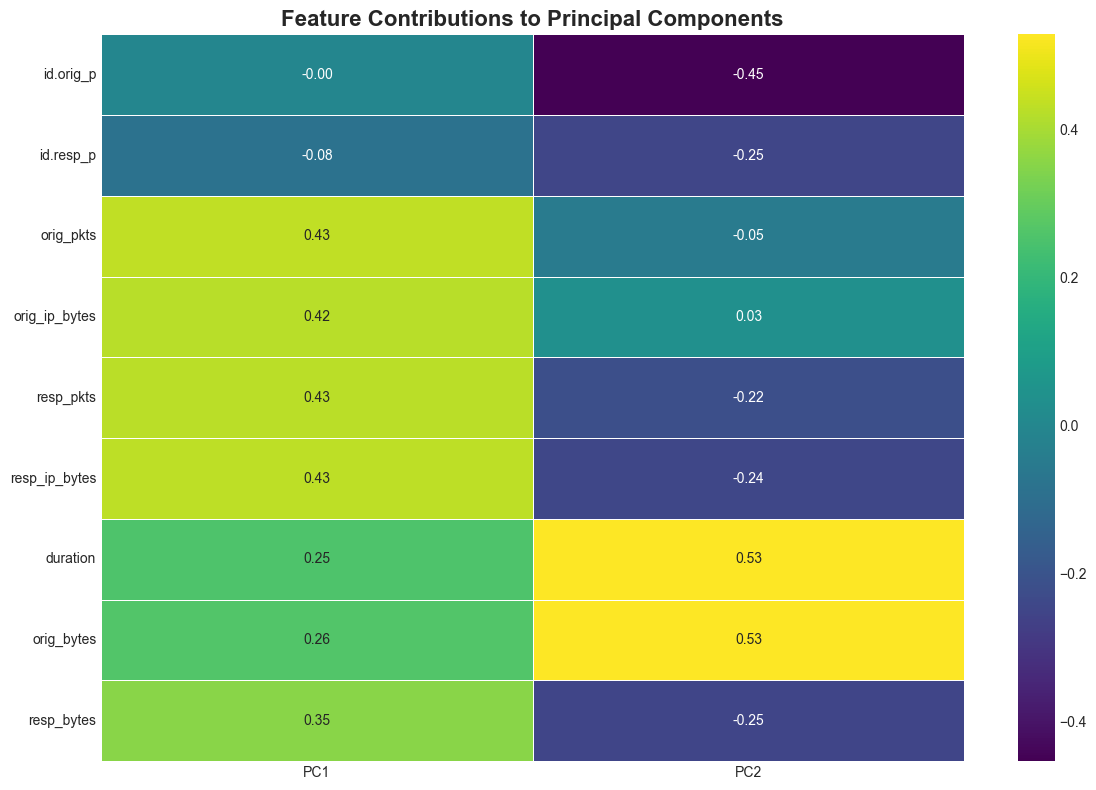


=== Analyzing CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv Missing Data ===
Dataset shape: 1008748 rows x 27 columns
Total missing values: 3185200 (11.69%)

Missing values by column:
  duration: 796300 missing values (78.94%)
  orig_bytes: 796300 missing values (78.94%)
  resp_bytes: 796300 missing values (78.94%)
  total_bytes: 796300 missing values (78.94%)

Numeric columns with zero values (potential placeholders):
  id.resp_p: 3334 zeros (0.33%)
  orig_bytes: 195511 zeros (19.38%)
  resp_bytes: 198819 zeros (19.71%)
  missed_bytes: 1008748 zeros (100.00%)
  orig_pkts: 45 zeros (0.00%)
  orig_ip_bytes: 45 zeros (0.00%)
  resp_pkts: 988854 zeros (98.03%)
  resp_ip_bytes: 988854 zeros (98.03%)
  hour: 45307 zeros (4.49%)
  total_bytes: 195492 zeros (19.38%)


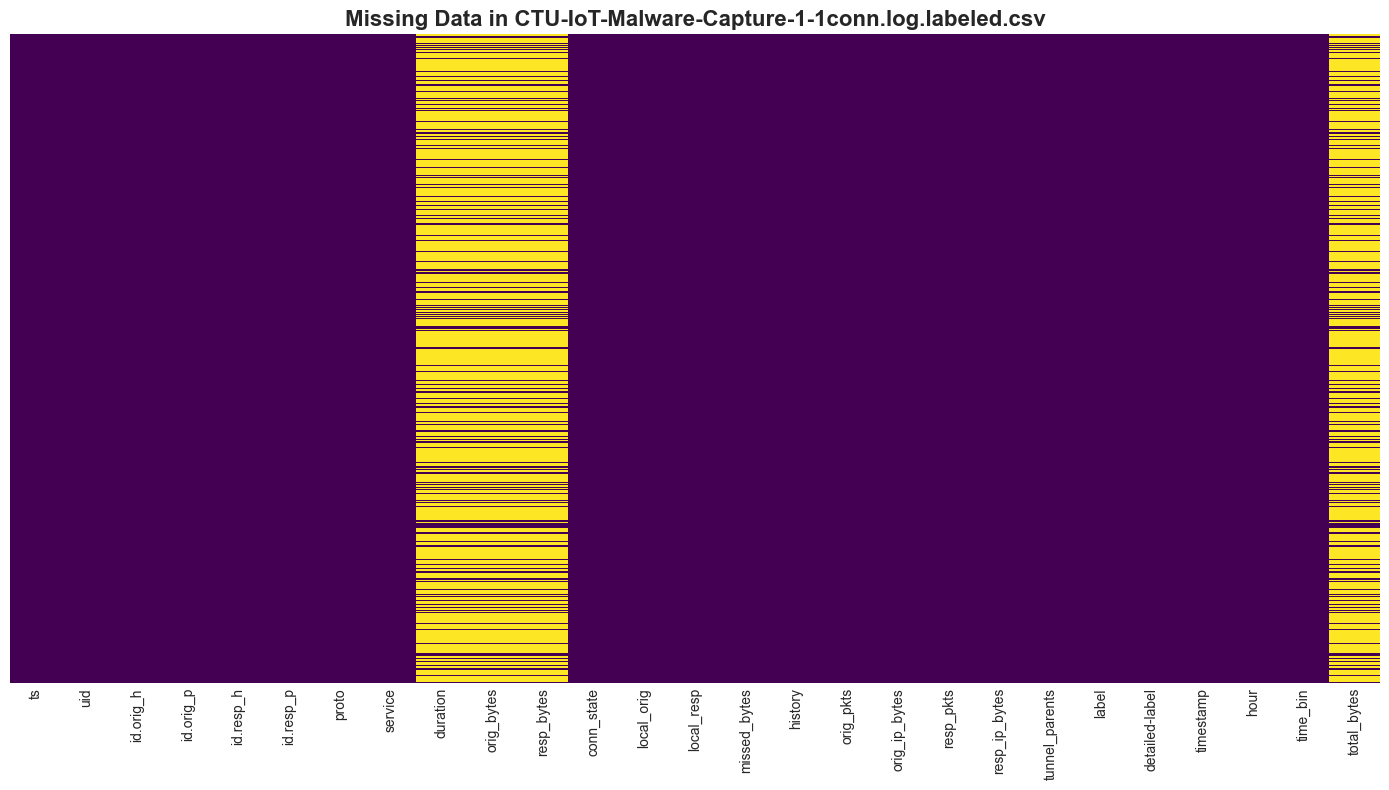


=== Data Preprocessing ===
Handling missing values...
Converting categorical variables...
Preparing features and target...
Normalizing features...
Training set: 806998 samples
Testing set: 201750 samples
Preprocessed data saved to c:\Users\user\OneDrive - Coventry University\documents\GitHub\Msc.Dissertation-Blessing-Ekwunife\data\processed\processed_data.npz

=== Training Traditional ML Models ===

=== Training Random Forest Classifier ===
Random Forest parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 1, 'warm_start': False}
Fitting Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished


Random Forest training completed in 0:03:23.127044
Random Forest model saved to c:\Users\user\OneDrive - Coventry University\documents\GitHub\Msc.Dissertation-Blessing-Ekwunife\models\random_forest.pkl

=== Training XGBoost Classifier ===
XGBoost parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42

KeyError: '[55985, 304994, 626264, 285834, 327704, 748173, 568924, 505122, 520600, 7228, 393993, 350973, 243680, 420145, 180453, 582133, 57348, 491961, 391155, 436822, 569798, 671206, 85180, 672737, 680547, 33398, 435810, 771006, 676327, 347595, 653971, 5026, 754504, 497498, 350760, 550718, 734382, 702652, 505239, 404986, 672586, 650343, 704853, 803686, 400488, 315091, 250081, 545129, 665143, 711055, 587476, 239701, 415888, 207702, 291676, 340972, 126111, 645552, 164273, 192882, 219004, 509670, 805593, 30007, 579242, 755284, 673392, 588116, 696912, 599765, 495558, 648110, 173821, 230833, 41658, 116843, 363233, 119553, 367145, 358302, 288106, 390460, 496748, 579102, 766087, 390648, 116443, 319592, 700325, 434356, 489970, 204262, 34210, 479803, 539311, 612806, 90101, 352354, 644019, 362337, 155698, 190549, 314555, 90311, 770726, 122870, 314690, 543713, 52771, 548050, 138942, 52696, 591768, 73232, 745840, 638576, 379538, 709792, 486656, 540418, 477382, 164287, 354146, 533108, 23087, 773959, 163238, 670921, 699467, 116354, 108295, 704780, 631826, 512547, 624530, 573980, 445120, 127597, 544782, 356210, 168757, 451406, 207107, 44119, 573280, 185039, 661226, 438294, 151260, 328702, 588616, 113130, 335883, 485993, 797698, 786714, 609176, 782822, 314331, 458981, 401779, 720631, 299219, 203656, 248960, 359363, 528676, 367027, 452787, 254150, 632894, 331308, 756952, 270608, 480752, 137958, 295871, 250945, 787937, 662722, 319237, 660676, 427744, 147935, 384066] not in index'

In [23]:
def main():
    print("\n=====================================================")
    print("IOT NETWORK MALWARE DETECTION PIPELINE")
    print("=====================================================")
    
    # Step 1: Download dataset
    dataset_downloaded = download_dataset()
    if not dataset_downloaded:
        print("Proceeding with existing data if available...")
    
    # Step 2: List available datasets and choose one to analyze
    csv_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
    if csv_files:
        print("\nAvailable datasets:")
        for i, file in enumerate(csv_files):
            print(f"{i+1}. {file}")
        
        # Choose the first dataset for analysis
        selected_file = csv_files[0]
        print(f"\nSelected dataset for analysis: {selected_file}")
        
        # Step 3: Load and analyze dataset
        df = load_dataset(selected_file)
        if df is not None:
            # Step 4: Perform data analysis
            perform_basic_analysis(df)
            analyze_temporal_patterns(df)
            analyze_traffic_features(df)
            perform_dimensionality_reduction(df)
            
            # Step 5: Analyze missing data
            analyze_file_missing_data(df, selected_file)
            
            # Step 6: Preprocess data
            X_train, X_test, y_train, y_test, features, encoders = preprocess_data(df)
        else:
            # Try to load preprocessed data if dataset loading failed
            X_train, X_test, y_train, y_test, features, encoders = load_preprocessed_data()
    else:
        print("No datasets found. Please download the dataset first.")
        X_train, X_test, y_train, y_test, features, encoders = load_preprocessed_data()
    
    # Step 7: Train and evaluate models if data is available
    if X_train is not None and y_train is not None:
        # Train traditional ML models
        print("\n=== Training Traditional ML Models ===")
        
        rf_model = train_random_forest(X_train, y_train)
        xgb_model = train_xgboost(X_train, y_train)
        svm_model = train_svm(X_train, y_train)
        
        # Evaluate traditional ML models
        print("\n=== Evaluating Traditional ML Models ===")
        
        results = {}
        
        if rf_model is not None:
            results['Random Forest'] = evaluate_model(rf_model, X_test, y_test, "Random Forest", features)
        
        if xgb_model is not None:
            results['XGBoost'] = evaluate_model(xgb_model, X_test, y_test, "XGBoost", features)
        
        if svm_model is not None:
            results['SVM'] = evaluate_model(svm_model, X_test, y_test, "SVM")
        
        # Compare traditional ML models
        if len(results) > 1:
            metrics_table = compare_models(results, y_test)
        
        # Step 8: Train and evaluate neural network
        print("\n=== Training Neural Network Model ===")
        
        input_size = X_train.shape[1]
        nn_model, training_history = train_neural_network(
            X_train, y_train, X_test, y_test, 
            input_size=input_size,
            batch_size=128,
            epochs=30,
            learning_rate=0.001,
            patience=7
        )
        
        # Evaluate neural network
        nn_results = evaluate_neural_network(nn_model, X_test, y_test)
        
        # Step 9: Compare all models
        if results:
            all_metrics = compare_all_models(results, nn_results)
            
            print("\n=== Final Model Recommendations ===")
            best_model_f1 = all_metrics.loc[all_metrics['F1 Score'].idxmax(), 'Model']
            best_model_accuracy = all_metrics.loc[all_metrics['Accuracy'].idxmax(), 'Model']
            
            print(f"Best model by F1 Score: {best_model_f1}")
            print(f"Best model by Accuracy: {best_model_accuracy}")
            
            print("\nRecommendation:")
            print(f"Based on the results, we recommend using the {best_model_f1} model for IoT malware detection.")
            print("This model provides the best balance between precision and recall, crucial for security applications.")
    else:
        print("Unable to proceed with model training. Please ensure data is properly loaded.")
    
    print("\n=== Pipeline Complete ===")
    print(f"All results and visualizations have been saved in {REPORTS_DIR} and {FIGURES_DIR}")

if __name__ == "__main__":
    main()